### Chest X-Ray (Pneumonia): Transfer Learning (a)

Using Several estandard models trained on Imagenet \
This example uses a ResNet152V2 network + some additional layers \
Only the new added layers are trained, the layers from the original ResNet152V2 network are not trained 

Train accuracy 96% \
Val accuracy 96% \
Test accuracy 96% \
ROC 99%

We perform two variants, one training new layers and another training the last 13 layers of the ResNet152V2 Net \
This notebook adds a balancing calculation in both variants \ 
We use adaptive learning rate as well

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from keras.applications.resnet import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# folder structure 
#Notebook folder
#    !------ chest_xray_data
#                  !-------------train
#                          !-------------normal
#                          !-------------pneumonia
#                  !-------------test
#                          !-------------normal
#                          !-------------pneumonia
#                  !-------------val
#                          !-------------normal
#                          !-------------pneumonia

main_path = "./chest_xray_data/"
train_path = os.path.join(main_path,"TRAIN")
test_path = os.path.join(main_path,"TEST")
val_path  = os.path.join(main_path,"VALIDATION")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

COUNT_NORMAL = len(train_normal)+len(test_normal)+len(val_normal)
COUNT_PNEUMONIA = len(train_pneumonia)+len(test_pneumonia)+len(val_pneumonia)

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), 
                      columns = ['class'])
df_val['image'] = [x for x in val_list]

train_df = df_train
test_df = df_test
val_df = df_val
print ('shapes. Train: ',train_df.shape, 'val : ', val_df.shape, 'test : ',test_df.shape)

shapes. Train:  (4099, 2) val :  (879, 2) test :  (878, 2)


In [5]:
# to improve class balancing we calculate the weights to add to the training process

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

calculated_class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


### Data Preparation 

In [6]:
print ('shapes. Train: ',train_df.shape, 'val : ', val_df.shape, 'test : ',df_test.shape)
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                            rotation_range=20,
                            width_shift_range=0.1,
                            shear_range=10,
                            horizontal_flip = True,
                            fill_mode = 'nearest',
                            zoom_range=0.2
#                           samplewise_center=True
)

val_datagen  = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

shapes. Train:  (4099, 2) val :  (879, 2) test :  (878, 2)
Found 4099 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.


### Transfer Learning 
#### Adding new layers to previously trained network and training only  new added layers

This approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/. 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.

We train only the new layers, leaving the ResNet152V2 network with the original Imagenet Training

In [7]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=False
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [8]:
base_model = tf.keras.applications.ResNet152V2(      
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [9]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
                    , optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [10]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          class_weight = calculated_class_weight,
          callbacks=[early_stopping_cb,checkpoint_cb]);

Epoch 1/50
129/129 [==============================] - 1026s 8s/step - loss: 0.9016 - binary_accuracy: 0.8595 - val_loss: 0.7722 - val_binary_accuracy: 0.6894
Epoch 2/50
129/129 [==============================] - 925s 7s/step - loss: 0.2202 - binary_accuracy: 0.9097 - val_loss: 0.4201 - val_binary_accuracy: 0.8612
Epoch 3/50
129/129 [==============================] - 967s 8s/step - loss: 0.1948 - binary_accuracy: 0.9253 - val_loss: 0.2690 - val_binary_accuracy: 0.9033
Epoch 4/50
129/129 [==============================] - 850s 7s/step - loss: 0.1907 - binary_accuracy: 0.9322 - val_loss: 0.2944 - val_binary_accuracy: 0.8987
Epoch 5/50
129/129 [==============================] - 688s 5s/step - loss: 0.1953 - binary_accuracy: 0.9273 - val_loss: 0.3822 - val_binary_accuracy: 0.8703
Epoch 6/50
129/129 [==============================] - 684s 5s/step - loss: 0.2031 - binary_accuracy: 0.9232 - val_loss: 0.2189 - val_binary_accuracy: 0.9090
Epoch 7/50
129/129 [==============================] - 687

#### CNN Training evaluation

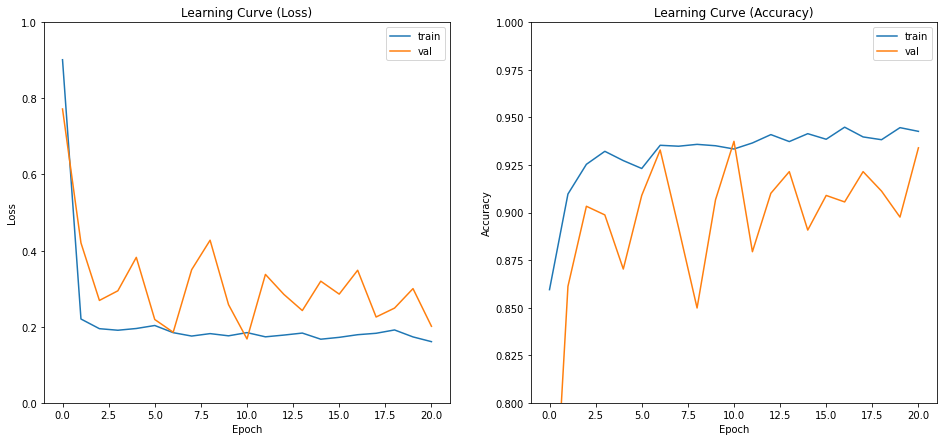

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,7))
sns.lineplot(x = history.epoch, y = history.history['loss'], ax=ax1)
sns.lineplot(x = history.epoch, y = history.history['val_loss'], ax=ax1)
ax1.set_title('Learning Curve (Loss)')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylim(0, 1)
ax1.legend(['train', 'val'], loc='best')
#
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'], ax=ax2)
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'], ax=ax2)
ax2.set_title('Learning Curve (Accuracy)')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylim(0.80, 1.0)
ax2.legend(['train', 'val'], loc='best')
plt.show()

In [12]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1678057760000229
Val accuracy: 0.937428891658783


In [13]:
score = model_pretrained.evaluate(ds_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15132391452789307
Test accuracy: 0.9430524110794067


### Result Performance Evaluation</a> 

In [14]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test_df['class'].copy().map(num_label).astype('int')

In [15]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [16]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9430523917995444


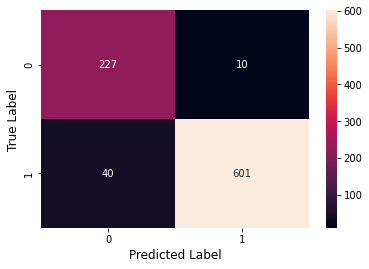

In [17]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [18]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       237
           1       0.98      0.94      0.96       641

    accuracy                           0.94       878
   macro avg       0.92      0.95      0.93       878
weighted avg       0.95      0.94      0.94       878



ROC_AUC:  0.9898497205711014


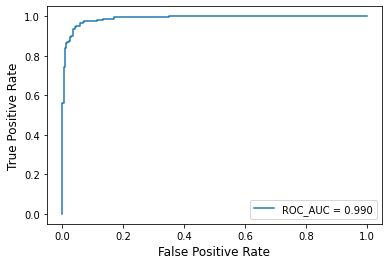

In [19]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()